# MSCS 634 – Project Deliverable 2
## Regression Modeling and Performance Evaluation
# Suresh Ghimire, Sagar Bhetwal, Nirajan Acharya, Umesh Dhakal, Enjal Chauhan
**Dataset:** `bank-cleaned.csv`

**Objective:** Predict **`age`** using feature engineering, multiple regression models, and cross-validation.

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Train-test split and cross-validation
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Regression models
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso


# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True         

In [65]:
# Loading the cleaned data
df = pd.read_csv(r"data/bank-cleaned.csv")

print("Shape:", df.shape)
display(df.head())

Shape: (45211, 22)


,age,job,marital,education,default,balance,housing,loan,contact,day,...,campaign,pdays,previous,poutcome,y,prev_contacted,job_unknown,education_unknown,contact_unknown,poutcome_unknown
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,...,1,NaN,0,unknown,0,0,0,0,1,1
1,44,technician,single,secondary,no,29,yes,no,unknown,5,...,1,NaN,0,unknown,0,0,0,0,1,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,...,1,NaN,0,unknown,0,0,0,0,1,1
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,...,1,NaN,0,unknown,0,0,0,1,1,1
4,33,unknown,single,unknown,no,1,no,no,unknown,5,...,1,NaN,0,unknown,0,0,1,1,1,1


## Feature Engineering
We create additional features that can improve linear model fit.

In [66]:
# Target variable
target = "age"

df_fe = df.copy()

# Non-linear age feature
df_fe["age_squared"] = df_fe["age"] ** 2

# Flag missing pdays
df_fe["pdays_was_missing"] = df_fe["pdays"].isna().astype(int)

# Fill missing pdays
df_fe["pdays_filled"] = df_fe["pdays"].fillna(0)

# Campaign intensity relative to previous contacts
df_fe["campaign_per_previous"] = df_fe["campaign"] / (df_fe["previous"] + 1.0)
display(df_fe[["age","age_squared","pdays","pdays_was_missing","pdays_filled","campaign","previous","campaign_per_previous"]].head())

,age,age_squared,pdays,pdays_was_missing,pdays_filled,campaign,previous,campaign_per_previous
0,58,3364,NaN,1,0.0,1,0,1.0
1,44,1936,NaN,1,0.0,1,0,1.0
2,33,1089,NaN,1,0.0,1,0,1.0
3,47,2209,NaN,1,0.0,1,0,1.0
4,33,1089,NaN,1,0.0,1,0,1.0


## Preprocessing Pipeline
Numeric: impute median + scale. Categorical: impute most frequent + one-hot encode.

In [67]:
# Separating features and target
X = df_fe.drop(columns=[target])
y = df_fe[target]

# Training-testing split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

numeric_features = X_train.select_dtypes(include=["int64","float64","int32","float32"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object","category","bool"]).columns.tolist()
print(numeric_features)
print(categorical_features)

# # Numeric feature preprocessing
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical feature preprocessing
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Preprocessing setup
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)
preprocessor

['balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'y', 'prev_contacted', 'job_unknown', 'education_unknown', 'contact_unknown', 'poutcome_unknown', 'age_squared', 'pdays_was_missing', 'pdays_filled', 'campaign_per_previous']
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['balance', 'day', 'duration', 'campaign',
                                  'pdays', 'previous', 'y', 'prev_contacted',
                                  'job_unknown', 'education_unknown',
                                  'contact_unknown', 'poutcome_unknown',
                                  'age_squared', 'pdays_was_missing',
                                  'pdays_filled', 'campaign_per_previous']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['job', 'marital', 'education', 'default',
                                  'housing', 'loan', 'contact', 'month',
                                  'poutcome'])])

## Model Training, Cross-Validation, and Test Evaluation

In [68]:
# Test-set evaluation
def evaluate_on_testset(model_pipeline):
    model_pipeline.fit(X_train, y_train)
    preds = model_pipeline.predict(X_test)
    
    # Calculating key regression metrics
    r2 = r2_score(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)  # RMSE is in the same units as the target (balance)
    return r2, mse, rmse, preds

# # Cross-validation- K-Fold
def cv_evaluate(model_pipeline, cv_splits=5):
    cv = KFold(n_splits=cv_splits, shuffle=True, random_state=RANDOM_STATE)
    
      # Scoring setup
    scoring = {"r2": "r2", "neg_mse": "neg_mean_squared_error"}
    
    # Run CV in parallel (n_jobs=-1) to save time
    cv_res = cross_validate(model_pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    r2_scores = cv_res["test_r2"]
    rmse_scores = np.sqrt(-cv_res["test_neg_mse"]) # Flip sign back to positive for RMSE
    return r2_scores, rmse_scores

# 3 differnt Models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge(alpha=1.0)": Ridge(alpha=1.0, random_state=RANDOM_STATE),
    "Lasso(alpha=0.001)": Lasso(alpha=0.001, random_state=RANDOM_STATE, max_iter=5000)
}

results = []
pred_store = {}

# Training and evaluateing each model
for name, estimator in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocessor), ("model", estimator)])
    cv_r2, cv_rmse = cv_evaluate(pipe, cv_splits=5)
    test_r2, test_mse, test_rmse, preds = evaluate_on_testset(pipe)
    pred_store[name] = preds
    
    # Collecting all metrics for a summary table
    results.append({
        "Model": name,
        "CV R2 mean": cv_r2.mean(),
        "CV R2 std": cv_r2.std(),
        "CV RMSE mean": cv_rmse.mean(),
        "CV RMSE std": cv_rmse.std(),
        "Test R2": test_r2,
        "Test MSE": test_mse,
        "Test RMSE": test_rmse
    })
results_df = pd.DataFrame(results).sort_values("CV RMSE mean")
display(results_df)

,Model,CV R2 mean,CV R2 std,CV RMSE mean,CV RMSE std,Test R2,Test MSE,Test RMSE
1,Ridge(alpha=1.0),0.981085,0.000801,1.460161,0.042098,0.981067,2.135445,1.461316
0,LinearRegression,0.981085,0.000801,1.460164,0.042099,0.981067,2.135414,1.461305
2,Lasso(alpha=0.001),0.981082,0.000808,1.460275,0.042399,0.981059,2.136378,1.461635


## Visualizations

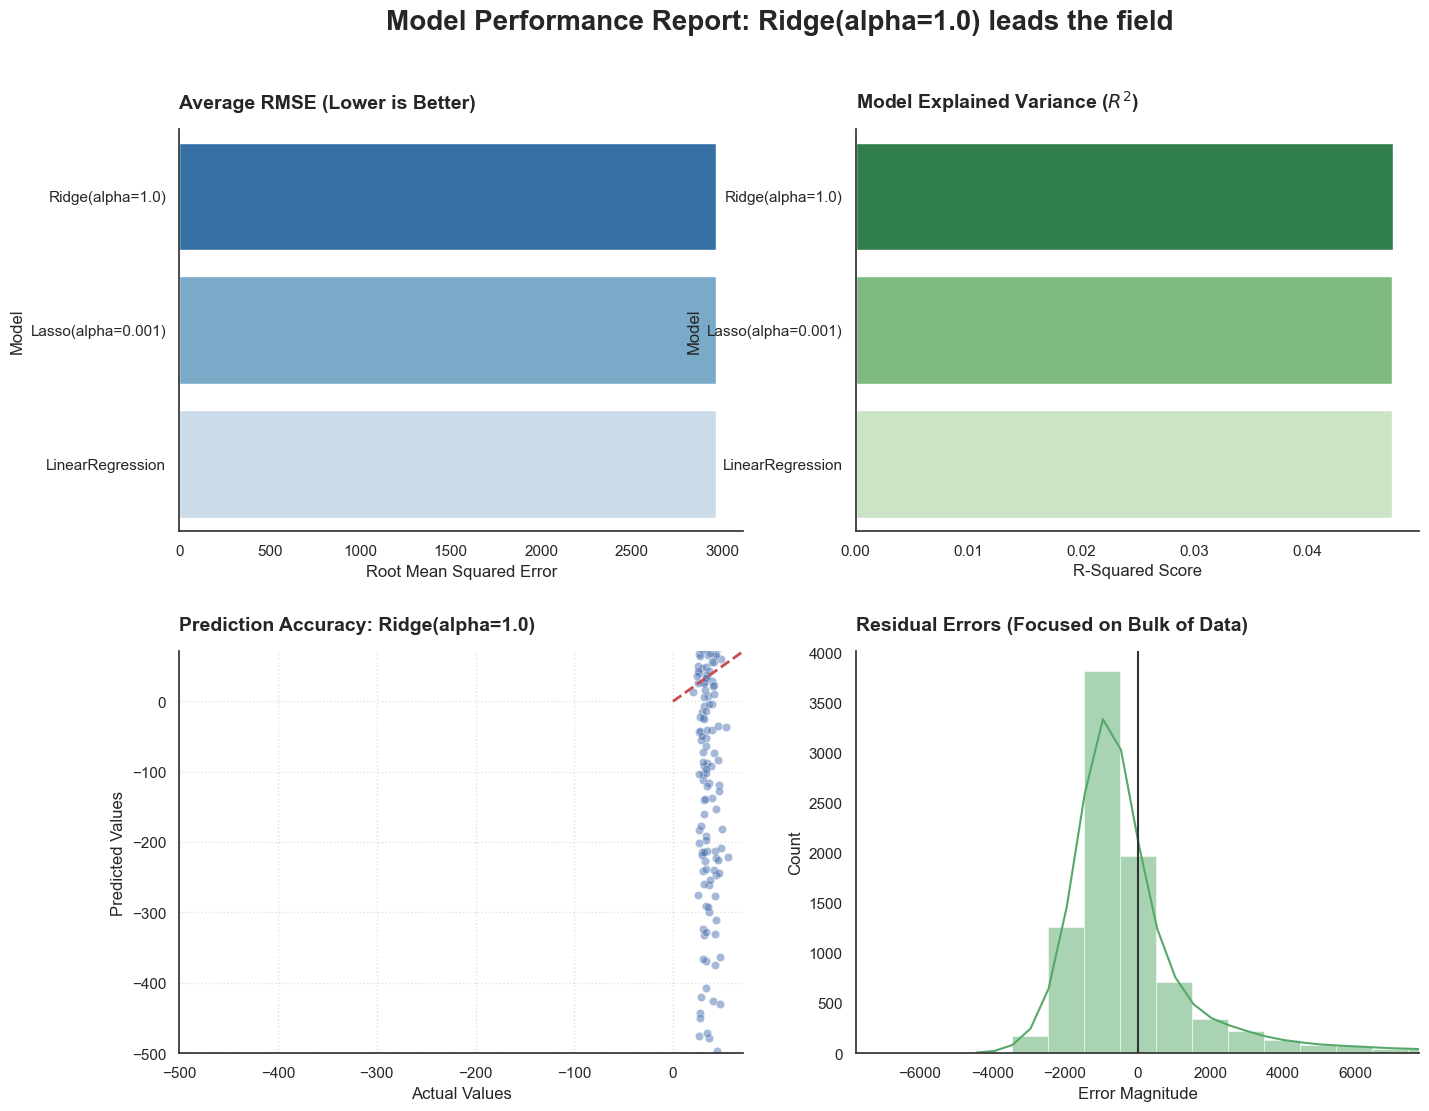

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Global Styling
sns.set_theme(style="white", palette="muted")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["axes.edgecolor"] = "#333333"

zoom_limit = np.percentile(y_test, 99)
res_limit = np.percentile(np.abs(residuals), 98) # Focus on 98% of error distribution

# Create a layout
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.2)

ax1 = fig.add_subplot(gs[0, 0])
sns.barplot(x="CV RMSE mean", y="Model", data=results_df_sorted, palette="Blues_r", ax=ax1, hue="Model", legend=False)
ax1.set_title("Average RMSE (Lower is Better)", loc='left', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel("Root Mean Squared Error")

ax2 = fig.add_subplot(gs[0, 1])
sns.barplot(x="CV R2 mean", y="Model", data=results_df_sorted, palette="Greens_r", ax=ax2, hue="Model", legend=False)
ax2.set_title("Model Explained Variance ($R^2$)", loc='left', fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel("R-Squared Score")

ax3 = fig.add_subplot(gs[1, 0])
sns.scatterplot(x=y_test, y=best_preds, alpha=0.5, edgecolor="w", color="#4c72b0", ax=ax3)

ax3.plot([0, zoom_limit], [0, zoom_limit], color='#c44e52', lw=2, linestyle='--')

ax3.set_xlim(-500, zoom_limit) 
ax3.set_ylim(-500, zoom_limit)

ax3.set_title(f"Prediction Accuracy: {best_model_name}", loc='left', fontsize=14, fontweight='bold', pad=15)
ax3.set_xlabel("Actual Values")
ax3.set_ylabel("Predicted Values")
ax3.grid(True, linestyle=':', alpha=0.6)

ax4 = fig.add_subplot(gs[1, 1])
sns.histplot(residuals, kde=True, color="#55a868", ax=ax4, bins=100)
ax4.axvline(0, color='#333333', linestyle='-', lw=1.5)

ax4.set_xlim(-res_limit, res_limit)

ax4.set_title(f"Residual Errors (Focused on Bulk of Data)", loc='left', fontsize=14, fontweight='bold', pad=15)
ax4.set_xlabel("Error Magnitude")

# Final Polish
plt.suptitle(f"Model Performance Report: {best_model_name} leads the field", fontsize=20, fontweight='black', y=0.98)
sns.despine()
plt.savefig("model_performance_report.png", dpi=300, bbox_inches='tight')
plt.show()